# Imports

In [1]:
!pip install -U tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_addons
    Found existing installation: tensorflow-addons 0.14.0
    Uninstalling tensorflow-addons-0.14.0:
      Successfully uninstalled tensorflow-addons-0.14.0


In [2]:
# Common
import keras
import numpy as np
import tensorflow as tf
from tensorflow import image as tfi

# Data
from keras.datasets import cifar100

# Data Viz
import matplotlib.pyplot as plt

# Data Aug
from keras.layers import Normalization
from keras.layers import Resizing
from keras.layers import RandomFlip
from keras.layers import RandomRotation
from keras.layers import RandomZoom


# Model
from tensorflow.nn import gelu
from keras.models import Model
from keras.layers import Dense
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import MultiHeadAttention
from keras.layers import LayerNormalization
from keras.layers import Add
from keras.layers import Flatten

# Compiling
from keras.losses import SparseCategoricalCrossentropy as SCCe
from tensorflow_addons.optimizers import AdamW
from keras.metrics import SparseCategoricalAccuracy as Acc
from keras.metrics import SparseTopKCategoricalAccuracy as KAcc

# Callbacks 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# **Functions**

In [3]:
def show_image(image, title=None, cmap=None):
    plt.imshow(image, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# **Load Data**

In [4]:
batch_size = 100
img_height = 32
img_width = 32

In [5]:
(X_train, y_train), (X_valid, y_valid) = cifar100.load_data()

training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

169017344/169001437 [==============================] - 3s 0us/step
Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


## **Model Parameters**

In [6]:
SIZE = 72
PATCH_SIZE = 6
LR = 0.001
WEIGHT_DECAY = 0.0001
EPOCHS = 100
NUM_PATCHES = (SIZE // PATCH_SIZE) ** 2
PROJECTION_DIMS = 64
NUM_HEADS = 4
HIDDEN_UNITS = [PROJECTION_DIMS*2, PROJECTION_DIMS]
OUTPUT_UNITS = [2048,1024]

## 1. **Data Augmentation**

In [7]:
class DataAugmentation(Layer):
    def __init__(self, norm, SIZE):
        super(DataAugmentation, self).__init__()
        self.norm = norm
        self.SIZE = SIZE
        self.resize = Resizing(SIZE, SIZE)
        self.flip = RandomFlip('horizontal')
        self.rotation = RandomRotation(factor=0.02)
        self.zoom = RandomZoom(height_factor=0.2, width_factor=0.2)
    def call(self, X):
        x = self.norm(X)
        x = self.resize(x)
        x = self.flip(x)
        x = self.rotation(x)
        x = self.zoom(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
        "norm": self.norm,
        "SIZE": self.SIZE,
        })
        return config

## 2. **Image-to-Patches**

In [8]:
class Patches(Layer):

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0] # Get the Batch Size
        patches = tfi.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1], # only along the Height and Width Dimension
            strides=[1, self.patch_size, self.patch_size, 1], # The next patch should not overlap the previus patch
            rates=[1,1,1,1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            "path-size": self.patch_size,
        })
        return config

Let's see how his works 

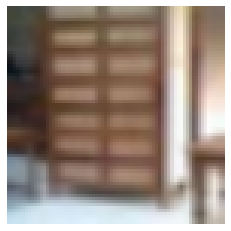

In [9]:
image = X_train[np.random.randint(len(X_train))]
image = tfi.resize(image, (SIZE, SIZE))
image = tf.cast(image,'uint8')
show_image(image)
image = tf.expand_dims(image,0)

In [10]:
patch = Patches(PATCH_SIZE) # patch Size
patches = patch(image)

In [11]:
patches.shape # We needed 12 patches

TensorShape([1, 144, 108])

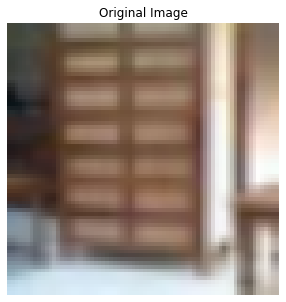

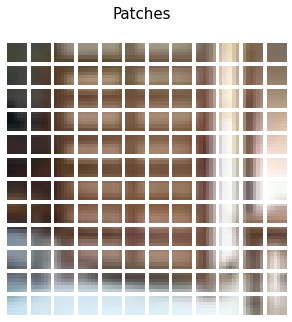

In [12]:
plt.figure(figsize=(5,5))
show_image(image[0], title="Original Image")
plt.show()

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(5,5))
plt.suptitle("Patches", fontsize=15)
for i in range(patches.shape[-2]):
    plt.subplot(n,n,i+1)
    patch = tf.reshape(patches[0][i],(PATCH_SIZE, PATCH_SIZE, 3))
    patch = tf.cast(patch, 'uint8')
    show_image(patch, cmap='gray')
plt.show()

## 3. **MLP**
---
Patches MLP

In [13]:
class PatchEncoder(Layer):

    def __init__(self, num_patches, projection_dims): # Projection dims is  D
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.d = projection_dims

        self.dense = Dense(units=projection_dims)
        self.positional_embeddings = Embedding(input_dim=num_patches, output_dim=projection_dims)

    def call(self, X):
        positions = tf.range(0,limit=self.num_patches, delta=1)
        encoded = self.dense(X) + self.positional_embeddings(positions)
        return encoded
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_paches": self.num_patches,
            "d": self.d,
        })
        return config

## 4. **MLP**
---
Output MLP

In [14]:
class MLP(Layer):
    def __init__(self, units, rate):
        super(MLP, self).__init__()
        self.units = units
        self.rate = rate
        self.layers = [[Dense(unit, activation=gelu), Dropout(rate)] for unit in units]

    def call(self, x):
        for layers in self.layers:
          for layer in layers:
            x = layer(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "rate": self.rate,
        })
        return config

## **Transformet Network**

In [15]:
class Transformer(Layer):

    def __init__(self, L, num_heads, key_dims, hidden_units):
        super(Transformer, self).__init__()
        self.L = L
        self.heads = num_heads
        self.key_dims = key_dims
        self.hidden_units = hidden_units

        self.norm = LayerNormalization(epsilon=1e-6) # Remember the Params
        self.MHA = MultiHeadAttention(num_heads=num_heads, key_dim=key_dims, dropout=0.1)
        self.net = MLP(units=hidden_units, rate=0.1)
        self.add= Add()

    def call(self, X):
        inputs = X
        x = X
        for _ in range(self.L):
          x = self.norm(x)
          x = self.MHA(x,x) # our Target and the Source element are the same
          y = self.add([x,inputs])
          x = self.norm(y)
          x = self.net(x)
          x = self.add([x,y])
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "L": self.L,
            "heads": self.heads,
            "key_dims":self.key_dims,
            "hidden_units":self.hidden_units
        })
        return config

## **ViT Structure**

In [16]:
class_names = training_ds.class_names

In [17]:
input_shape = X_train.shape[1:]
print(f'Input Image Shape : {input_shape}')

Input Image Shape : (32, 32, 3)


In [18]:
# Input Layer
inputs = Input(shape=input_shape)

# Apply Data Aug
norm = Normalization()
norm.adapt(X_train)

x = DataAugmentation(norm, SIZE)(inputs)

# Get Patches
x = Patches(PATCH_SIZE)(x)

# PatchEncoding Network
x = PatchEncoder(NUM_PATCHES, PROJECTION_DIMS)(x)

# Transformer Network
x = Transformer(8, NUM_HEADS, PROJECTION_DIMS, HIDDEN_UNITS)(x)

# Output Network
x = LayerNormalization(epsilon=1e-6)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

x = MLP(OUTPUT_UNITS, rate=0.5)(x)

# Ouput Layer
outputs = Dense(100)(x)

## **ViT Model**

In [19]:
with tf.device('/GPU:0'):
  # Model
  model = Model(
    inputs=[inputs],
    outputs=[outputs],
  )

  # Compiling
  model.compile(
      loss=SCCe(from_logits=True),
      optimizer=AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
      metrics=[
          Acc(name="Accuracy"),
          KAcc(5, name="Top-5-Accuracy")
      ]
  )

  # Callbacks
  cbs = [
    ModelCheckpoint("ViT-Model.h5", save_best_only=True)
  ]

  

In [20]:
# Fit
results = model.fit(
      training_ds,
      epochs=EPOCHS,
      validation_data=validation_ds,
      callbacks=cbs
  )

Epoch 1/100
8/8 [==============================] - 17s 365ms/step - loss: 4.8293 - Accuracy: 0.4387 - Top-5-Accuracy: 0.8875 - val_loss: 1.9559 - val_Accuracy: 0.6020 - val_Top-5-Accuracy: 1.0000
Epoch 2/100
8/8 [==============================] - 5s 173ms/step - loss: 2.3919 - Accuracy: 0.6030 - Top-5-Accuracy: 1.0000 - val_loss: 1.5543 - val_Accuracy: 0.5714 - val_Top-5-Accuracy: 1.0000
Epoch 3/100
8/8 [==============================] - 4s 170ms/step - loss: 1.6746 - Accuracy: 0.5689 - Top-5-Accuracy: 1.0000 - val_loss: 0.8282 - val_Accuracy: 0.5510 - val_Top-5-Accuracy: 1.0000
Epoch 4/100
8/8 [==============================] - 4s 168ms/step - loss: 1.1297 - Accuracy: 0.5828 - Top-5-Accuracy: 1.0000 - val_loss: 0.8779 - val_Accuracy: 0.5510 - val_Top-5-Accuracy: 1.0000
Epoch 5/100
8/8 [==============================] - 4s 167ms/step - loss: 0.9736 - Accuracy: 0.5879 - Top-5-Accuracy: 1.0000 - val_loss: 0.6095 - val_Accuracy: 0.6939 - val_Top-5-Accuracy: 1.0000
Epoch 6/100
8/8 [=======

# Viewing Results

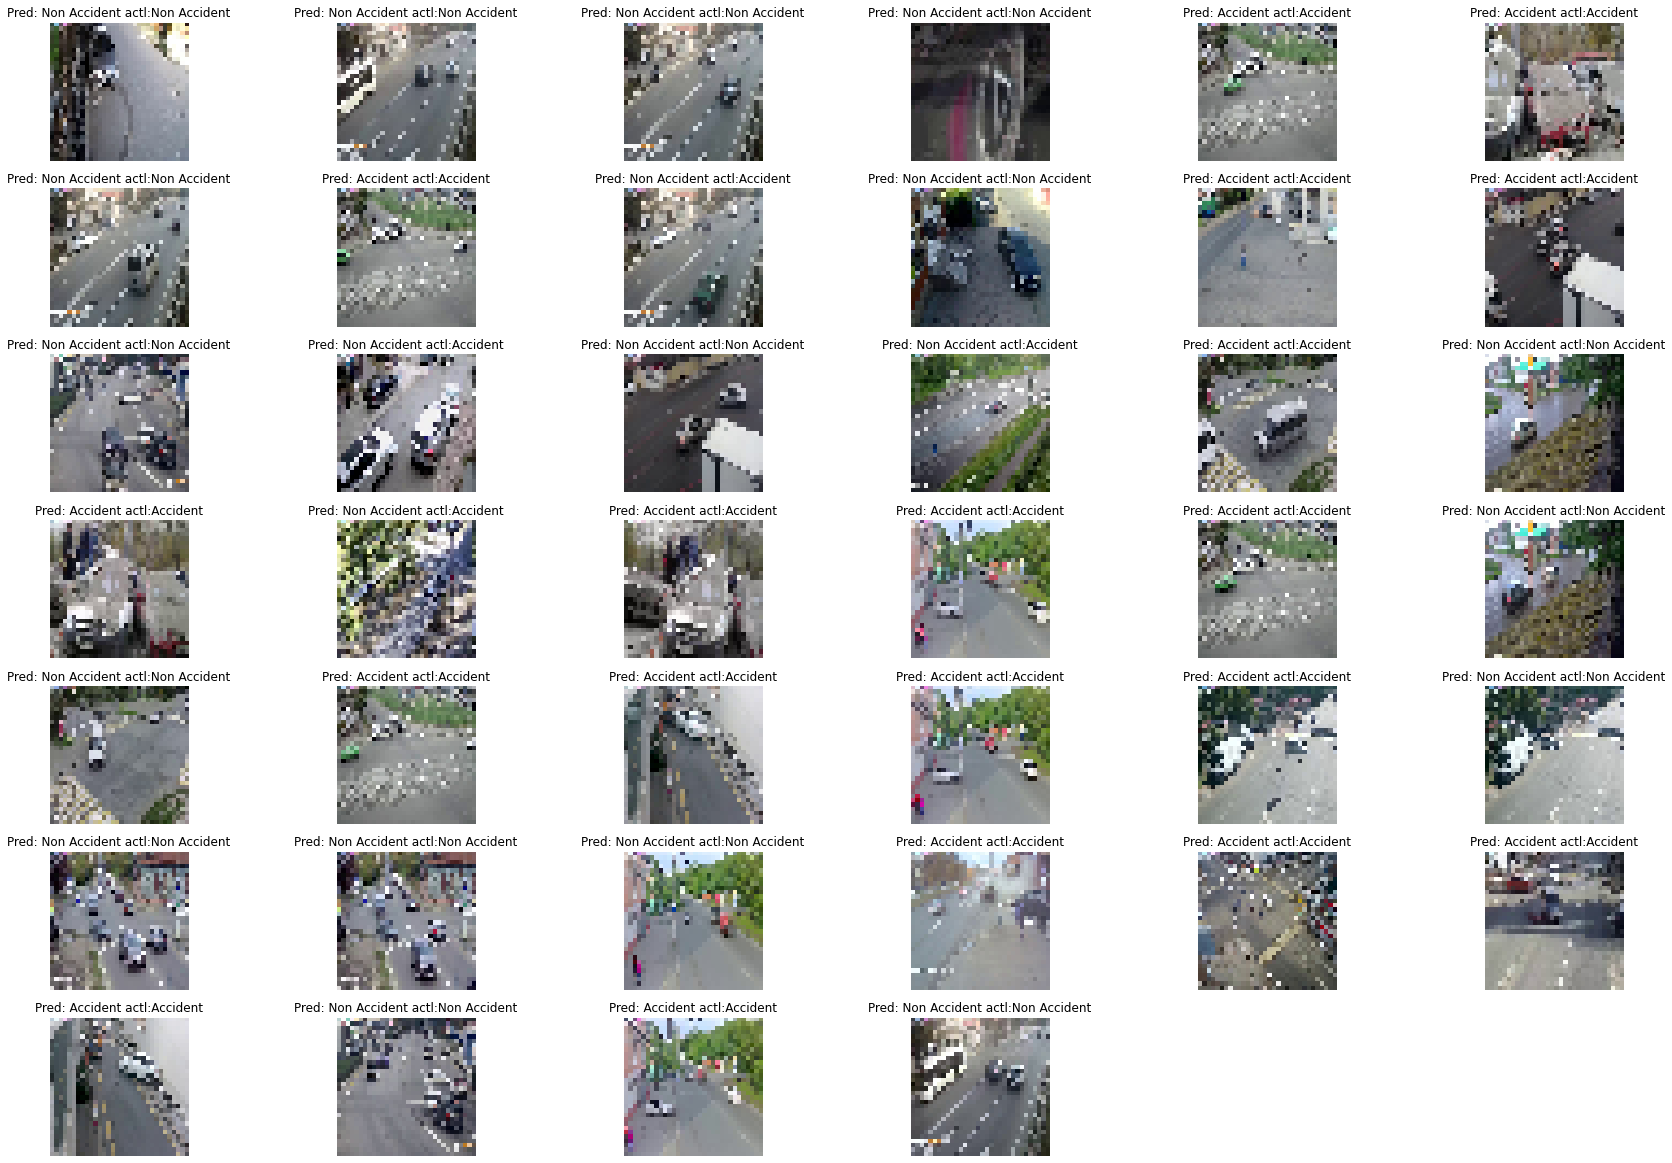

In [21]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

# Confusion Matrix

In [22]:
truePositive=0
trueNegative=0
falsePositive=0
falseNegative=0
#positive event is accident negative event is non accident
for i in range(0,100):
    if(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Accident'):
        truePositive+=1
    elif(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Non Accident'):
        trueNegative+=1
    elif(predlabel[i]=='Non Accident' and class_names[labels[i]]=='Accident'):
        falseNegative+=1
    else:
        falsePositive+=1

In [23]:
print(f'True positives are: {truePositive}')
print(f'True negatives are: {trueNegative}')
print(f'False negatives are: {falseNegative}')
print(f'False positives are: {falsePositive}')

True positives are: 40
True negatives are: 50
False negatives are: 7
False positives are: 3


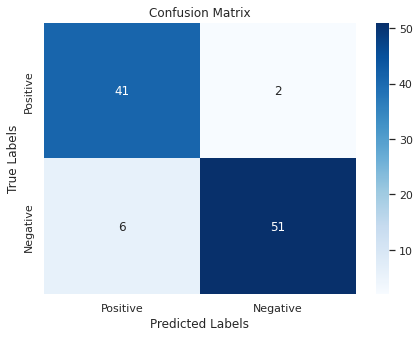

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

true_positives = 41
true_negatives = 51
false_negatives = 6
false_positives = 2

confusion_mat = confusion_matrix([1, 0, 1, 0], [1, 0, 0, 1],
                                  labels=[1, 0],
                                  sample_weight=[true_positives, true_negatives, false_positives, false_negatives])

labels = ['Positive', 'Negative']

sns.set()
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



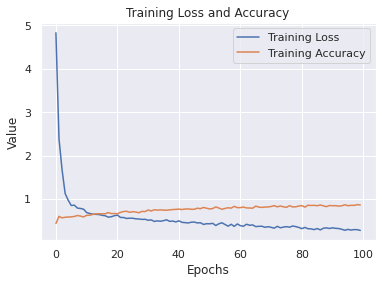

In [25]:
import matplotlib.pyplot as plt

# Assuming 'results' contains the training history
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['Accuracy'], label='Training Accuracy')  # Change to 'accuracy' if that's the metric you're using
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

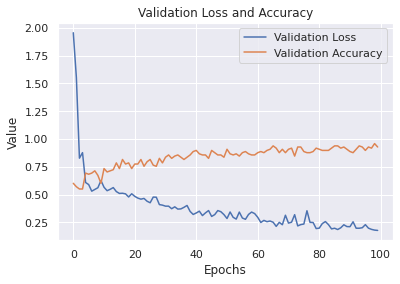

In [26]:
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.plot(results.history['val_Accuracy'], label='Validation Accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()
plt.show()

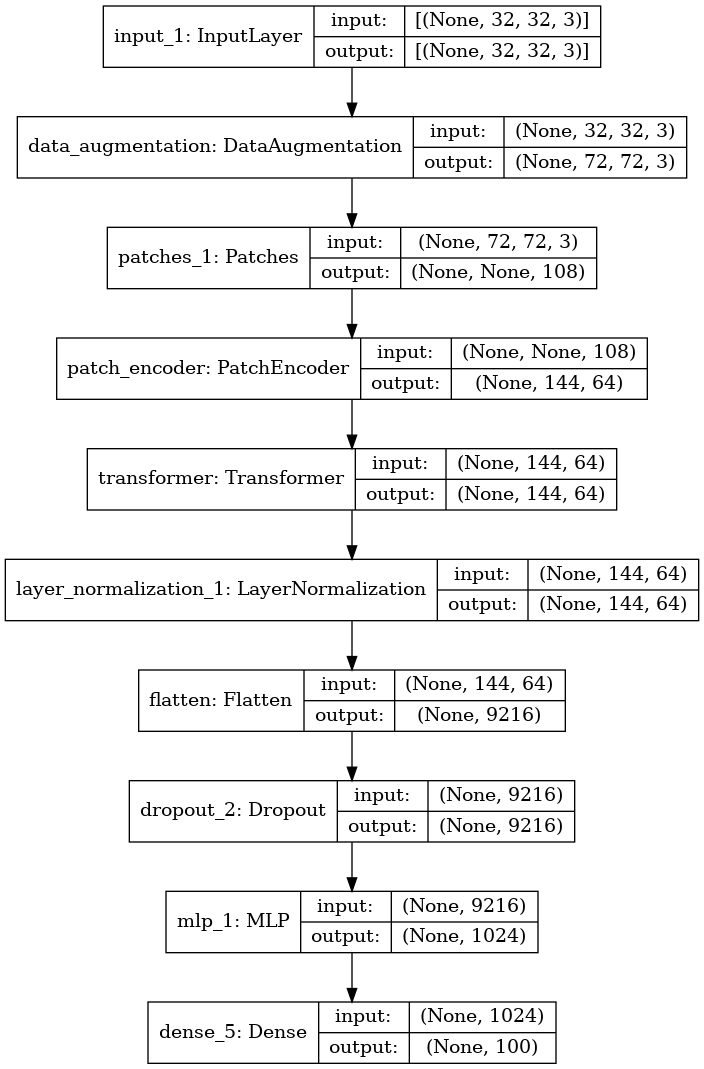

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# CNN for comparison

In [28]:
## import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
batch_size = 100
img_height = 32
img_width = 32
img_shape = (img_height, img_width, 3)

training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


In [29]:


base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu',padding="same"),
    layers.Conv2D(16, 3, activation='relu',padding="same"),
    layers.Flatten(),
    layers.Dense(len(class_names), activation= 'softmax')
])
cbs = [
    ModelCheckpoint("CNN-Model.h5", save_best_only=True)
  ]
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_ds, validation_data = validation_ds, epochs = 100,callbacks=cbs)

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/100
8/8 [==============================] - 13s 222ms/step - loss: 0.6919 - accuracy: 0.5676 - val_loss: 0.6920 - val_accuracy: 0.5306


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
8/8 [==============================] - 3s 68ms/step - loss: 0.6892 - accuracy: 0.5815 - val_loss: 0.6911 - val_accuracy: 0.5204
Epoch 3/100
8/8 [==============================] - 3s 75ms/step - loss: 0.6863 - accuracy: 0.5841 - val_loss: 0.6907 - val_accuracy: 0.5204
Epoch 4/100
8/8 [==============================] - 4s 69ms/step - loss: 0.6834 - accuracy: 0.5815 - val_loss: 0.6908 - val_accuracy: 0.5306
Epoch 5/100
8/8 [==============================] - 3s 68ms/step - loss: 0.6802 - accuracy: 0.5853 - val_loss: 0.6914 - val_accuracy: 0.5306
Epoch 6/100
8/8 [==============================] - 4s 68ms/step - loss: 0.6773 - accuracy: 0.5853 - val_loss: 0.6916 - val_accuracy: 0.5306
Epoch 7/100
8/8 [==============================] - 3s 68ms/step - loss: 0.6749 - accuracy: 0.5866 - val_loss: 0.6929 - val_accuracy: 0.5306
Epoch 8/100
8/8 [==============================] - 4s 69ms/step - loss: 0.6724 - accuracy: 0.5891 - val_loss: 0.6930 - val_accuracy: 0.5306
Epoch 9/100
8/8 [===

Comparing CNN result with ViT

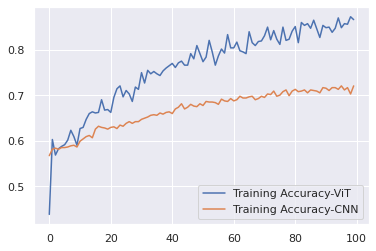

In [30]:
plt.plot(results.history['Accuracy'], label = 'Training Accuracy-ViT')
plt.plot(history.history['accuracy'], label = 'Training Accuracy-CNN')
plt.grid(True)
plt.legend()